# Inicjalizacja środowiska

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
warnings.filterwarnings('ignore')
from math import log

## Funkcje pomocnicze

In [127]:
def searchBestCValue(solver, penalty, X_train, y_train, X_val, y_val, min, max, step):
    scores = []
    values = []
    for C in np.arange(min, max, step):
        model = LogisticRegression(random_state=None, solver=solver, penalty=penalty, C=C).fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = metrics.f1_score(y_true=y_val, y_pred=y_pred)
        score = metrics.accuracy_score(y_val, y_pred)
        scores.append(score)

        values.append(C)
    return scores, values

def testModelParameters(solver, penalty, X_train, y_train, X_val, y_val, plot=True, print_result=True):
    #0.1 2 0.01
    #0.01, 20, 0.5
    val_scores, values = searchBestCValue(solver, penalty, X_train, y_train, X_val, y_val, 0.01, 100, 1)
    if (plot):
        plt.figure()
        plt.plot(values, val_scores)
        plt.show()
    max = np.max(val_scores)
    idx = val_scores.index(max)
    C = values[idx]
    if(print_result):
        print("Największa wartość Accuracy na zbiorze walidacyjnym: %.4f \ndla współczynnika C = %.4f" %(max, C))
    return solver, penalty, C, max


# Dane wypełnione medianami

## Wczytanie danych

In [110]:
data = pd.read_csv("data/imputated_data.csv")
data = data.drop(['Imputated'], axis=1)
data = data.drop(['Unnamed: 0'], axis=1)

## Dodanie dodatkowych cech

Funkcje interakcji najlepiej sprawdzają się w przypadku cech, które na wykresie cecha1(cecha2) układają się mniej więcej wzdłuż funkcji x=y oraz wraz z x rośnie prawdopodobieństwo wystąpienia pozytywnej decyzji. Z pomocą wykresów korelacji znalazłem jeden taki przypadek: Glucose oraz BMI.

In [115]:
data['InsulinSquared'] = data['Insulin'].apply(lambda x: x**2)
data['GlucoseSquared'] = data['Glucose'].apply(lambda x: x**2)
data['InsulinGlucose'] = data['Insulin'] * data['Glucose']
data['BMISquared'] = data['BMI'].apply(lambda x:(x**2))
data['GlucoseBMI'] = data['Glucose'] * data['BMI']
data['InsulinLog'] = data['Insulin'].apply(lambda x: log(x))
data['BloodPressureSquared'] =  data['BloodPressure'].apply(lambda x: x**2)
data['SkinThicknessBMI'] = data['BMI'] * data['SkinThickness']

## Podział danych
* Podział na zbiory X (cehcy opisujące) oraz Y (cecha opisywana). Dla tego zbioru Y to "Outcome", czyli diagnoza.
* Podział na zbiory Train/Test/Val - procentowy podział w komentarzu funkcji splitDataset()

In [91]:
def splitDataset(X, y, random_state=0, print_result=False):
    #Podział Train 60%, Test 20%, Val 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    #0.5 * 0.4 = 0.2
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
    print("Zbiór podzielony: TRAIN: %i, VAL: %i, TEST: %i" % (X_train.shape[0],X_val.shape[0],X_test.shape[0]))
    return X_train, y_train, X_test, y_test, X_val, y_val

In [120]:
y = data['Outcome']
X = data.drop(["Outcome"], axis=1)

In [121]:
X_train, y_train, X_test, y_test, X_val, y_val = splitDataset(X, y, random_state=5, print_result=True)

Zbiór podzielony: TRAIN: 451, VAL: 151, TEST: 150


### Wybór ilości cech

Do doboru cech wykorzystuje metodę zachłanną. Model ma jednak włączoną regularyzację Lasso, dzięki czemu przy okazji będzie pozbywał się lub redukował wpływ tych mniej znaczących cech zmniejszając ich szansę na zostanie wybraną w danym etapie. Dla każdego etapu dodatkowo liczone jest współczynnik regularyzacji oferujący najlepszy wynik miary Accuracy. Zaimplementowałem to, ponieważ dla różnych ilości cech modele działają najlepiej dla różnych wartości C. Ponieważ regularyzacja jest stosowana za każdym razem to nie trzeba się obawiać overfittingu (choć później dla pewności należy sprawdzić), dzięki czemu zastosowanie samej miary Accuracy powinno wystarczyć do tego zadania.

In [79]:
features = X.columns.values.tolist()
result_features = []

cv_scores = []
test_scores = []
feature_numbers = []

model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=4.1)
for n in range(0,len(features)):
    tmp_max_score = 0
    tmp_test_score = 0
    best_features = []
    for i,val in enumerate(features):
        tmp_features = result_features.copy()
        tmp_features.append(val)
        score = cross_val_score(model, X_train[tmp_features], y_train)
        score = np.abs(score).mean()
        fitted_model = model.fit(X_train[tmp_features], y_train)
        test_score = fitted_model.score(X_test[tmp_features], y_test)
        if( score > tmp_max_score ):
            tmp_max_score = score
            best_features = tmp_features
            tmp_test_score = test_score
    result_features = best_features
    print("Dla tego etapu najlepszy wynik wynosi cv_score: %.4f , test_score: %.4f dla zbioru cech:\n%s" % (tmp_max_score, tmp_test_score, str(best_features)))
    cv_scores.append(tmp_max_score)
    test_scores.append(tmp_test_score)
    feature_numbers.append(len(best_features))
    solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[best_features], y_train, X_val[best_features], y_val, plot=False, print_result=False)
    print("Dla najlepszego współczynnika C = %f maksymalna skuteczność na zbiorze walidacyjnym wynosi %.4f" % (C,max))
    print("___________________________________________________________________________")
    features.remove(best_features[len(best_features)-1])

Dla tego etapu najlepszy wynik wynosi cv_score: 0.7537 , test_score: 0.7467 dla zbioru cech:
['GlucoseBMI']
Dla najlepszego współczynnika C = 1.010000 maksymalna skuteczność na zbiorze walidacyjnym wynosi 0.7881
___________________________________________________________________________
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7537 , test_score: 0.7400 dla zbioru cech:
['GlucoseBMI', 'DiabetesPedigreeFunction']
Dla najlepszego współczynnika C = 6.010000 maksymalna skuteczność na zbiorze walidacyjnym wynosi 0.8013
___________________________________________________________________________
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7582 , test_score: 0.7667 dla zbioru cech:
['GlucoseBMI', 'DiabetesPedigreeFunction', 'BMI']
Dla najlepszego współczynnika C = 10.010000 maksymalna skuteczność na zbiorze walidacyjnym wynosi 0.8079
___________________________________________________________________________
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7537 , test_score: 0.7

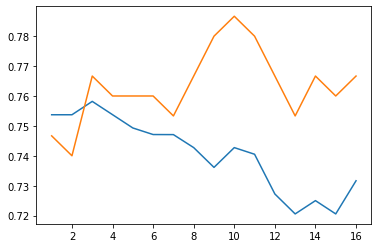

In [118]:
plt.figure()
plt.plot(feature_numbers, cv_scores)
plt.plot(feature_numbers, test_scores)
plt.show()

In [183]:
features = ['GlucoseBMI', 'DiabetesPedigreeFunction', 'BMI', 'GlucoseSquared', 'BloodPressure', 'BloodPressureSquared', 'SkinThickness', 'Age']

# Dobór parametrów

## Metoda regularyzacji
Ponieważ cechy są dobrane to model nie wymaga już redukcji ich wpływu lub usuwania, więc metoda Lasso nie jest tutaj oczywistym wyborem. Klasa LogisticRegression dla algorytmu liblinear oferuje regularyzacje L1 oraz L2. Wyboru można dokonać prostym porównaniem tych dwóch.

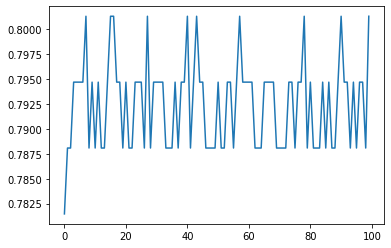

Największa wartość Accuracy na zbiorze walidacyjnym: 0.8013 
dla współczynnika C = 7.0100


In [184]:
solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[features], y_train, X_val[features], y_val)

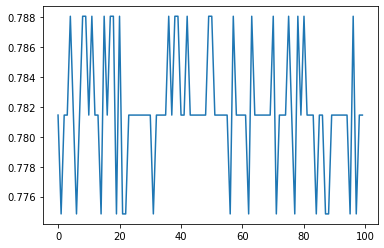

Największa wartość Accuracy na zbiorze walidacyjnym: 0.7881 
dla współczynnika C = 4.0100


In [185]:
solver, penalty, C, max = testModelParameters('liblinear','l2', X_train[features], y_train, X_val[features], y_val)

# Wynik, czyli teoretycznie najlepszy model

In [133]:
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=4.01).fit(X_train[features], y_train)

In [134]:
model.coef_

array([[ 8.24542553e-04,  6.51034464e-01, -2.68610478e-02,
         1.14827999e-05,  4.03333469e-02, -2.54516019e-04,
        -9.64211980e-04,  2.71935324e-02]])

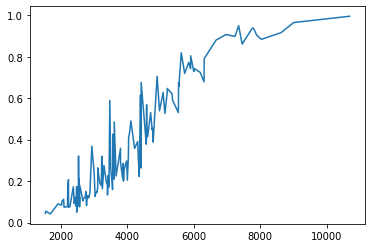

In [135]:
sorted = X_test.sort_values(by="GlucoseBMI")
model_values = (model.predict_proba(sorted[features]))
model_values[:,1]
plt.plot(sorted['GlucoseBMI'], model_values[:,1])

# Analiza utworzonego modelu

In [189]:
model = LogisticRegression(solver='liblinear', penalty='l1', C=4.1).fit(X_train[features], y_train) #4.1

In [190]:
y_pred = model.predict(X_test[features])

In [191]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1score = metrics.f1_score(y_test, y_pred)

In [192]:
print("Accuracy: %f\nPrecision: %f\nRecall: %f\nF1Score: %f" % (accuracy, precision, recall, f1score))

Accuracy: 0.786667
Precision: 0.717949
Recall: 0.571429
F1Score: 0.636364


In [193]:
metrics.confusion_matrix(y_test, y_pred)

array([[90, 11],
       [21, 28]], dtype=int64)

In [146]:
model.intercept_

array([-6.81755386])

In [164]:
model.classes_

array([0, 1], dtype=int64)

In [182]:
y_pred = 1*model.predict_proba(X_test[features])[:,1] > 0.2
metrics.confusion_matrix(y_test, y_pred)

array([[61, 40],
       [ 2, 47]], dtype=int64)

In [61]:
idx = 8
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1',C=1.69).fit(X_train, y_train)
prediction = model.predict_proba(X.iloc[idx,:].values.reshape(1,-1))
print(prediction)
prediction = model.predict(X.iloc[idx,:].values.reshape(1,-1))
print(prediction)
pinw = np.linalg.pinv(X_train)
w = np.dot(pinw,y_train)
prediction = (w*X.iloc[idx,:]).sum()
print(prediction)
print(y.iloc[idx])

[[0.17883669 0.82116331]]
[1]
0.6922917900197856
1


In [83]:
print("Metoda macierzowa")
y_pred = ((w*X_val).sum(axis=1) > 0.5) * 1
print(metrics.confusion_matrix(y_val, y_pred))

print("LogisticRegression")
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1',C=4.51).fit(X_train, y_train)
y_pred = model.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

Metoda macierzowa
[[92 12]
 [17 30]]
LogisticRegression
[[92 12]
 [15 32]]


In [17]:
y_pred = ((w*X_test).sum(axis=1) > 0.5) * 1
correct = (y_pred == y_test).sum()
correct/len(y_pred)

NameError: name 'w' is not defined

In [86]:
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1',C=1.69).fit(X_train, y_train)
model.score(X_test, y_test)
print(model.coef_)
y_pred = model.predict(X_val)
metrics.roc_auc_score(y_val,y_pred )

[[ 1.25840154e-01  6.08128459e-02 -1.71398830e-02  1.12659022e-03
   2.38570027e-02  1.04679083e-01  5.34846100e-01  1.00882071e-02
  -4.93796265e-05 -1.96511440e-04  1.06463493e-04 -1.31885213e-03
   5.94369528e-04 -2.83807672e+00]]


0.7508183306055647

In [35]:

model = LogisticRegression(random_state=None, solver='liblinear', penalty='l1', C=1.49).fit(X_train, y_train)
scores = cross_val_score(model, X, y, cv=5 )
print(scores)
print(model.coef_)

[0.7615894  0.74834437 0.76       0.78666667 0.77333333]
[[ 1.22858438e-01  7.52431789e-02 -1.43070719e-02 -2.80329383e-03
  -1.24195789e-02  8.60426555e-02  3.46797701e-01  1.05454765e-02
  -9.07960153e-06 -1.71996077e-04  9.62394085e-05]]


In [36]:

scores = cross_val_score(model, X, y, cv=5)
scores

array([0.7615894 , 0.74834437, 0.76      , 0.78666667, 0.77333333])

# Testowanie modelu #
#TODO

# Wypełnienie braków przy użyciu regresji
#TODO